# Exercise 6

In [1]:
# Basic
import random
from functools import reduce

# Data
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# ML
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

# DL
from tensorflow.keras.datasets import mnist

c:\Users\OmriG\AppData\Local\Programs\Python\Python39\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


## 1. Data

In [2]:
(X_train, y_train),(X_test, y_test) = mnist.load_data()
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=y_test.size, shuffle=True, random_state=42)

X_train = X_train / 255
X_val = X_val / 255
X_test = X_test / 255

(X_train.shape, y_train.shape), (X_val.shape, y_val.shape), (X_test.shape, y_test.shape)

(((50000, 28, 28), (50000,)),
 ((10000, 28, 28), (10000,)),
 ((10000, 28, 28), (10000,)))

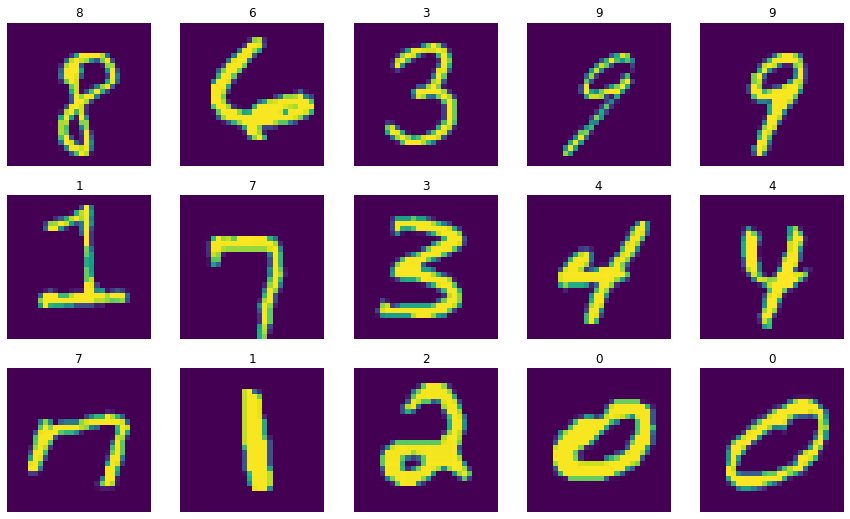

In [3]:
# Plot dimensions
ROWS, COLS = 3, 5
SCALE = 3

# Sampled images
pairs = list(zip(X_train, y_train))
samples = random.sample(pairs, ROWS * COLS)

# Plotting
fig, ax = plt.subplots(ROWS, COLS, figsize=(COLS * SCALE, ROWS * SCALE))
for i, (img, digit) in enumerate(samples):
    row, col = i // COLS, i % COLS
    ax[row, col].imshow(img)
    ax[row, col].set_title(digit)
    ax[row, col].axis('off')

## 2. Model

In [4]:
def softmax(x):
    exp = np.exp(x)
    return exp / np.sum(exp, axis=-1, keepdims=True)

In [5]:
class Activation:
    def func(self, x):
        assert False
        
    def grad(self, x):
        assert False
        
class ReLU(Activation):
    def func(self, x):
        return np.maximum(x, 0)

    def grad(self, x):
        return np.where(x > 0, 1, 0)

class Sigmoid(Activation):
    def func(self, x):
        return 1 / (1 + np.exp(-x))

    def grad(self, x):
        sig = sigmoid(x)
        return sig * (1 - sig)
    
class Tanh(Activation):
    def func(self, x):
        exp = np.exp(x)
        return (exp + (1 / exp)) / (exp - (1 / exp))
    
    def grad(self, x):
        return 1 - self.func(x) ** 2

In [6]:
class Optimizer:
    def __init__(self, weights, gradients):
        self.weights = weights
        self.gradients = gradients
        
    def step(gradients):
        assert False

class Adam(Optimizer):
    def __init__(self, weights, gradients, lr=3e-4, beta1=0.9, beta2=0.999):
        super().__init__(weights, gradients)
        
        self.t = 0
        self.beta1 = beta1
        self.beta2 = beta2
        self.mt = 0
        self.vt = 0
        self.lr = lr
        
    def step(self):
        self.t += 1
        
        # Update weights
        for layer, grad in enumerate(self.gradients):
            
            new_mt = self.beta1 * self.mt + (1 - self.beta1) * grad
            new_vt = self.beta2 * self.vt + (1 - self.beta2) * (grad**2)
            
            new_mt = new_mt / (1 - self.beta1 ** self.t)
            new_vt = new_vt / (1 - self.beta2 ** self.t)
            
            self.weights[layer] -= self.lr * new_mt / (np.sqrt(new_vt) + 1e-8)

In [7]:
class NeuralNetwork:
    def __init__(self, input_size, hidden_sizes, output_size, activation_type, optimizer_type, lr=3e-4, max_iter=1000, verbose=True):
        self.max_iter = max_iter
        
        self.layer_sizes = [input_size, *hidden_sizes, output_size]
        self.weights = [
            np.random.uniform(0, 1, size=(size_from, size_to)) / (size_from / 2)
            for size_from, size_to in zip(self.layer_sizes[:-1], self.layer_sizes[1:])
        ]
        self.gradients = [np.zeros_like(w) for w in self.weights]
        
        self.activation = activation_type()
        self.optimizer = optimizer_type(self.weights, self.gradients, lr)

    def forward(self, X):
        
        # Inputs for each layer (hidden & output)
        self.layer_inputs = [np.zeros((X.shape[0], size)) for size in self.layer_sizes[:-1]]
        self.activation_inputs = [np.zeros((X.shape[0], size)) for size in self.layer_sizes[1:]]
        
        # First layer inputs
        self.layer_inputs[0] = X
        
        # Calculate intermediate values
        for layer, weight in enumerate(self.weights[:-1]):
            
            # Linear layer
            self.activation_inputs[layer] = self.layer_inputs[layer] @ weight
            
            # Activation
            self.layer_inputs[layer + 1] = self.activation.func(self.activation_inputs[layer])
            
        # Last linear layer
        self.activation_inputs[-1] = self.layer_inputs[-1] @ self.weights[-1]
        
        # Logits
        self.output = softmax(self.activation_inputs[-1])
    
    def backward(self, y):
        
        # Zero gradients
        for grad in self.gradients:
            grad.fill(0)
        
        # Gradient of loss w.r.t to softmax input
        one_hot_labels = np.zeros_like(self.output)
        one_hot_labels[np.arange(y.size), y] = 1
        delta = self.output - one_hot_labels
        
        # Iterate over layers
        for layer in range(len(self.gradients) - 1, 0, -1):
            
            # Gradient of loss w.r.t layer weights
            self.gradients[layer] = self.layer_inputs[layer].T @ delta
            
            # Gradient of loss w.r.t to previous layer's input
            delta = self.activation.grad(self.activation_inputs[layer - 1]) * (delta @ self.weights[layer].T)

        # Last gradient of loss w.r.t first layer's weights
        self.gradients[0] = self.layer_inputs[0].T @ delta
        
        # Cross-Entropy loss
        self.loss = -np.log(softmax(self.activation_inputs[-1])[one_hot_labels.astype(bool)]).sum() / y.size

    def fit(self, X, y):

        # Iterating over data        
        for itr in range(1, self.max_iter + 1):
            
            self.forward(X)
            self.backward(y)
            self.optimizer.step()
            
            if itr % 100 == 0:
                print(f'iteration {itr}/{self.max_iter}')
                print(f'    loss: {self.loss}')

        return self

    def predict_proba(self, X):
        return softmax(reduce(lambda x, w: self.activation.func(x @ w), [X, *self.weights[:-1]]) @ self.weights[-1])

    def predict(self, X):
        return np.argmax(self.predict_proba(X), axis=1)    

    def score(self, X, y):
        return (self.predict(X) == y).sum() / len(y)

## 3. Training

In [8]:
X_train_flat = X_train.reshape(X_train.shape[0], -1)
X_val_flat = X_val.reshape(X_val.shape[0], -1)
X_test_flat = X_test.reshape(X_test.shape[0], -1)

In [9]:
nn_clf = NeuralNetwork(input_size=X_train_flat.shape[1], 
                       hidden_sizes=[256, 256],
                       output_size=np.unique(y_train).size,
                       activation_type=ReLU,
                       optimizer_type=Adam)

nn_clf.fit(X_train_flat, y_train)

iteration 100/1000
    loss: 2.0089686325981897
iteration 200/1000
    loss: 1.3391293493503869
iteration 300/1000
    loss: 0.5902459850527141
iteration 400/1000
    loss: 0.41592487972811265
iteration 500/1000
    loss: 0.34044260528706605
iteration 600/1000
    loss: 0.2986812590053463
iteration 700/1000
    loss: 0.2717487433314519
iteration 800/1000
    loss: 0.25172451933080925
iteration 900/1000
    loss: 0.23671475316734775
iteration 1000/1000
    loss: 0.2253492091083867


## 4. Evaluation

In [10]:
def plot_confusion_matrix(clf, X, y, tag):
    y_pred = clf.predict(X)
    cm = confusion_matrix(y_true=y, y_pred=y_pred)
    
    plt.figure(figsize=(15,10))
    sns.heatmap(cm, annot=cm)
    plt.ylabel("Ground Truth")
    plt.xlabel("Predictions")
    plt.title(f'{tag}: {clf.layer_sizes}, Score: {100 * clf.score(X, y):.2f}%')
    plt.show()

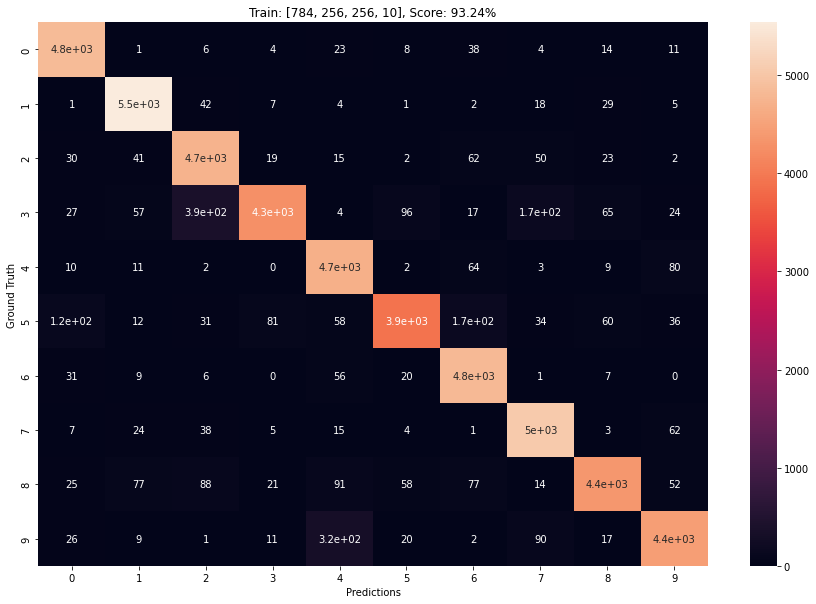

In [11]:
plot_confusion_matrix(nn_clf, X_train_flat, y_train, "Train")

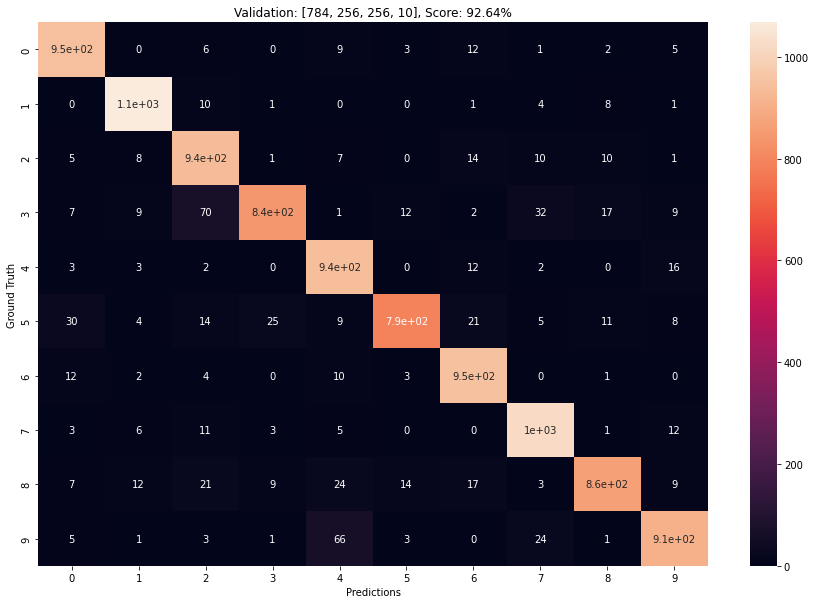

In [12]:
plot_confusion_matrix(nn_clf, X_val_flat, y_val, "Validation")

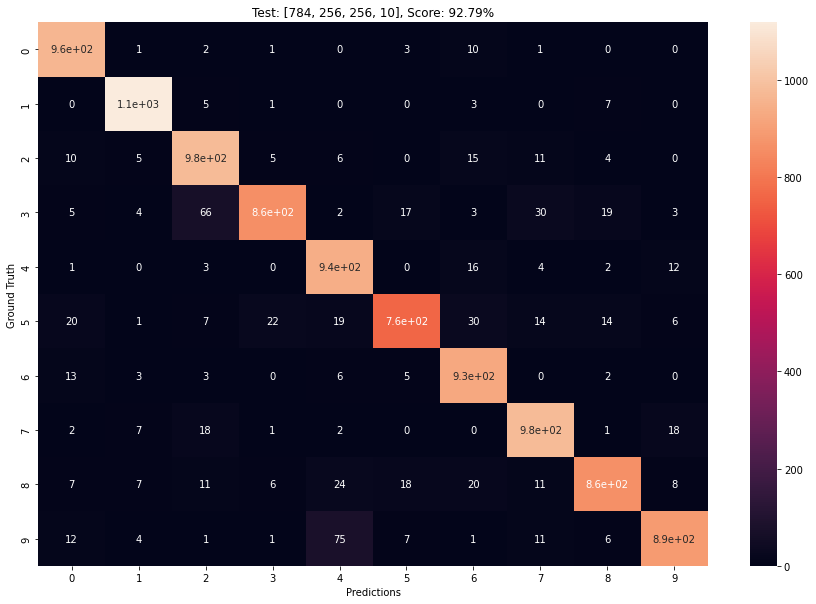

In [13]:
plot_confusion_matrix(nn_clf, X_test_flat, y_test, "Test")

## 5. Experiments

In [14]:
# TODO experiments